In [1]:
import pandas as pd
import json
from pathlib import Path
import numpy as np
from collections import defaultdict

In [2]:
df = pd.read_pickle("/home/beomyeol/Workspace/ibm/faro/data/6hr_augmented_top9_twitter_unscaled_sample.pkl")

In [3]:
keys = sorted(df.hash_func.unique())
print(keys)

['04605a37a22e05096e009845434d33bfd1c42cd67f6d72601d351e470614bf5f', '063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb', '0ce67779eaa33056a996ccdeabeb3c04e48d41388d5fa734c30f505d7583b559', '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc', '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e', '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170', 'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c', 'ea885ffca6338a2b781a0725ae8a661496779c7f0a7f78855b1f297b899640c0', 'f8c5d1ba78b7d2f4d2d2a0d8bbc31f0b93185edce1d0788fbc362f22bd931af2', 'twitter']


In [4]:
from sklearn.preprocessing import MinMaxScaler
scalers = {
    key: MinMaxScaler(feature_range=(1, 1600))
    for key in keys
}
for key in keys:
    scaler = scalers[key]
    scaler.fit(np.expand_dims(np.concatenate(df[df.hash_func == key].counts.values), -1))

In [5]:
hash_funcs = []
days = []
counts = []
samples = []

for i, r in df.iterrows():
    hash_funcs.append(r.hash_func)
    days.append(r.day)
    counts.append(pd.Series(np.clip(np.round(
        scalers[r.hash_func].transform(r.counts.to_numpy().reshape(-1, 1))).astype(np.int32).reshape(-1), 1, None)))
    samples.append(r["sample"])

In [6]:
scaled_df = pd.DataFrame({"hash_func": hash_funcs, "day": days, "counts": counts, "sample": samples})
scaled_df.to_pickle(f"{Path().resolve().name}.pkl", protocol=4)
scaled_df
not_augmented_df = scaled_df[scaled_df["sample"] == 0].drop(columns=["sample"])
not_augmented_df.to_pickle(f"{Path().resolve().name}.pkl".replace("_augmented", ""), protocol=4)

In [7]:
scaled_dfs = {}
for day in scaled_df.day.unique():
    scaled_dfs[day] = scaled_df[(scaled_df.day == day) & (scaled_df["sample"] == 0)]

In [8]:
def generate_count_dict(dfs):
    counts_dict = defaultdict(list)

    for day, df in sorted(dfs.items()):
        for _, row in df.iterrows():
            counts = row.counts
            counts_dict[row.hash_func].append(counts)

    return {
        hash_func: pd.concat(counts).reset_index(drop=True) for hash_func, counts in counts_dict.items()
    }

target_day = 11
count_dict = generate_count_dict({target_day: scaled_dfs[target_day]})
stacked_counts = np.stack(count_dict.values())
# print(stacked_counts[:, :5])
print(stacked_counts.shape)
print(stacked_counts.max(axis=1))

def generate_sim_input(path, count_dict, keys):
    lines = []

    for ts in np.arange(0, 360):
        d = defaultdict(dict)
        for i, k in enumerate(keys):
            v = count_dict[k]
            cluster = "serve-cluster%d" % i
            d[cluster]["classifier"] = int(v[ts])
        lines.append(json.dumps({"ts": int(ts), "counts": d}))
    Path(path).write_text("\n".join(lines))

generate_sim_input(f"input.json", count_dict, keys)

(10, 360)
[1418 1428 1210 1226 1477 1441  826 1243 1426 1375]


/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


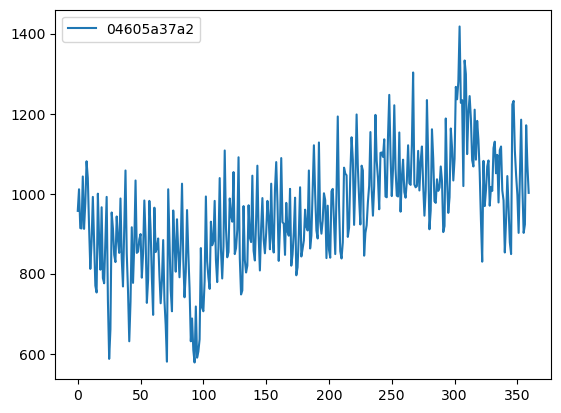

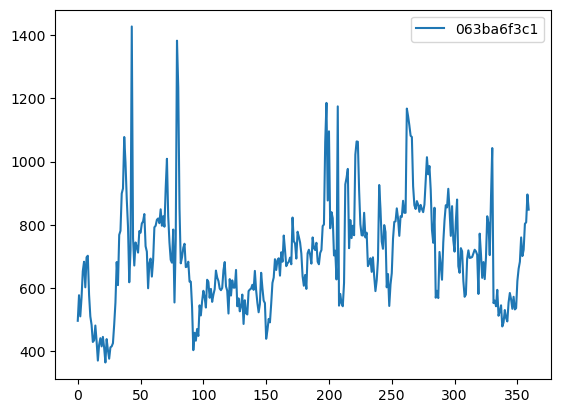

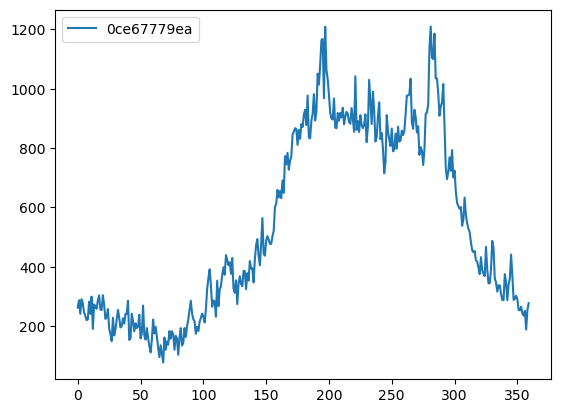

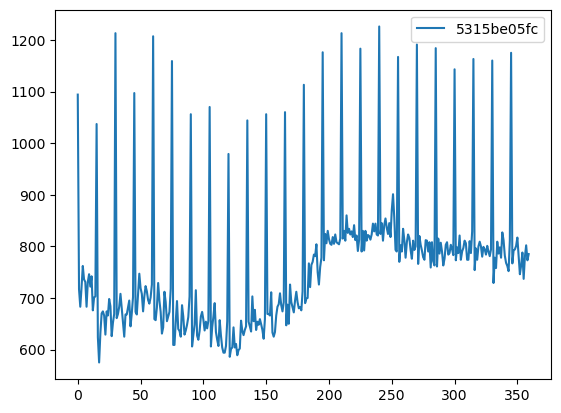

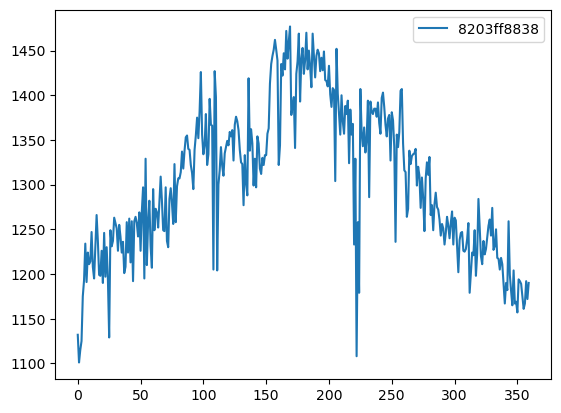

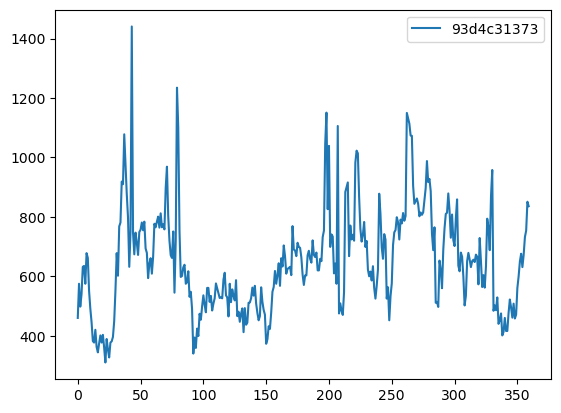

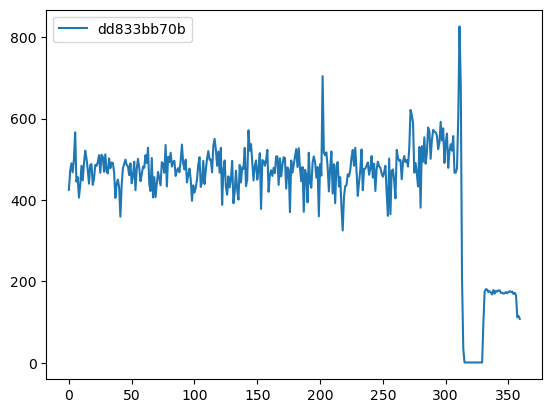

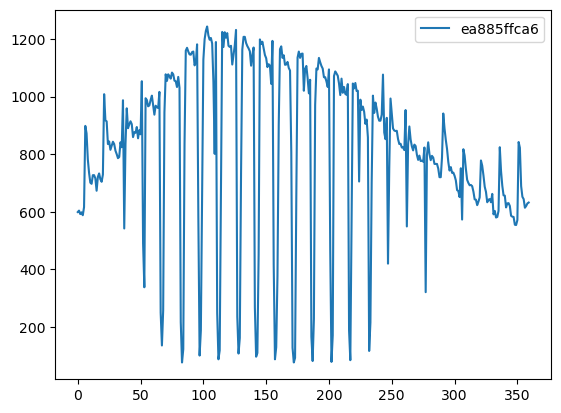

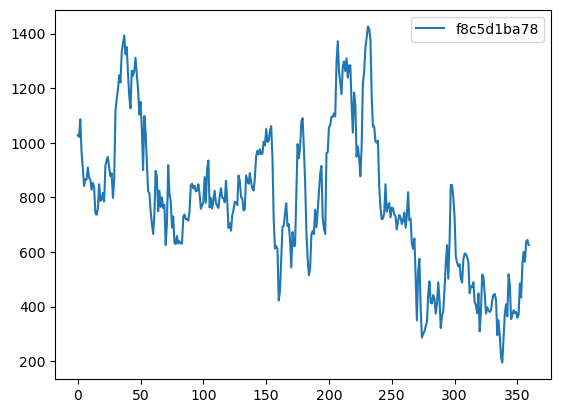

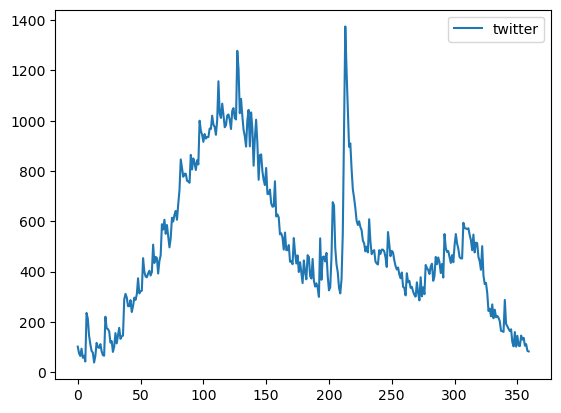

In [9]:
import matplotlib.pyplot as plt

for k, v in count_dict.items():
    _, ax = plt.subplots()
    ax.plot(v, label=k[:10])
    ax.legend()

# plt.plot(stacked_counts.sum(axis=0))

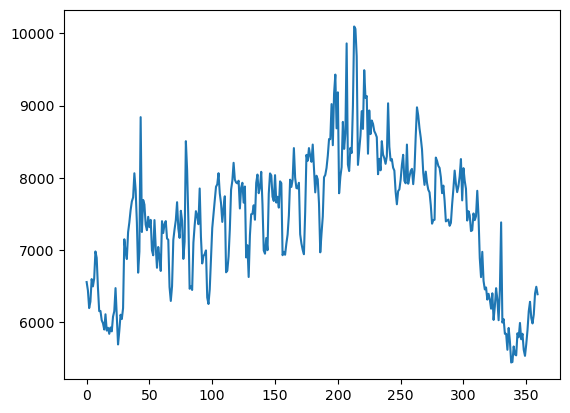

In [10]:
_, ax = plt.subplots()
ax.plot(stacked_counts.sum(axis=0), label=k[:10])